# XDGMM Bovy speed test

esutil and healpy should be installed 

In [1]:
import os, sys, time
import esutil
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

import time
from xdgmm import XDGMM
import warnings
warnings.filterwarnings('ignore')

In [2]:
# call required functions from modules 
sys.path.append('code_py3/')
from cmass_modules import io
from utils import matchCatalogsbyPosition, hpHEALPixelToRaDec, HealPixifyCatalogs, spatialcheck
from xd import mixing_color, doVisualization_1d, XDnew_fitting_X, XDastroML_fitting_X
from run_DMASS_Y3 import priorCut_test

# Construct training samples

We first need to load Y3 Gold catalogs in the overlapping region (training region) and split them into the cmass sample and non-cmass sample. 

In [3]:
# Calling Y3 GOLD v2.0 (training)
# All catalogs are in the 'input_path' directory 
# The 'SearchAndCallFits' function below loads all 
# catalogs in the directory including 'input_keyword' in its name
input_path = '../../data/gold_y3/'
# call only first 9 catalogs for a fast run.
# to call all catalogs in the directory, use 'Y3_GOLD' as input_keyword 
# but that will consume huge memory
#input_keyword = 'Y3_GOLD_2_0_STRIPE82_00000'  
input_keyword = 'gold_y3_stripe82_patch_00000'  
# Columns to call
columns =  ['RA', 'DEC', 
            'HPIX_4096',     # Healpix in ring order, nside=4096
            'COADD_OBJECT_ID', 
            'SOF_CM_MAG_CORRECTED_G', # mag_[griz]
            'SOF_CM_MAG_CORRECTED_R',
            'SOF_CM_MAG_CORRECTED_I',
            'SOF_CM_MAG_CORRECTED_Z',
            'SOF_CM_MAG_ERR_G',       # mag error_[griz]
            'SOF_CM_MAG_ERR_R',
            'SOF_CM_MAG_ERR_I',
            'SOF_CM_MAG_ERR_Z']
gold_st82 = io.SearchAndCallFits(path = input_path, keyword = input_keyword, columns=columns)

# Color/Magnitude cuts to exclude extremely high or low mag/color sources.
# 16 < mag_riz < 24, 0 < (r-i) < 1.5, 0 < (g-r) < 2.5
# These galaxies are less likeliy to be a CMASS, therefore unnecessary. 
# We apply these cuts to reduce the sample size to speed up the codes
mask_magcut = priorCut_test(gold_st82)
gold_st82 = gold_st82[mask_magcut]


Calling catalogs >>>
gold_y3_stripe82_patch_000002.fits
gold_y3_stripe82_patch_000001.fits
reading 1/2 ../../data/gold_y3/gold_y3_stripe82_patch_000002.fits
reading 2/2 ../../data/gold_y3/gold_y3_stripe82_patch_000001.fits


# Training the algorithm

In [11]:
# For a fast run, we draw a random sample to reduce the sample size. 
# Larger sample tends to make a better model but the sample size is not always proportional to the accuracy of the model. 

# Put sample size you want 
n_sample =  int(gold_st82.size/5)  # train cmass sample size
print('random sampling... ')
sampling_ind = np.random.choice(np.arange(gold_st82.size), size = n_sample)
gold_st82_sub = gold_st82[sampling_ind]
print('sample size =', n_sample)

random sampling... 
sample size = 33054


### Model Fitting

In [12]:
# number of gaussian mixtures
# Set None for a initial run. The algorithm automatically finds an optimal number
n_gold = None 

# number of XD iteration. 
# I set these numbers small for a fast run but generally
# should be run until the XD algorithm converges (more than 10000 iterations)
n_iter_gold = 5000
# tolerance
tol = 1E-5

# Fitted parameters and covariance will be stored as a pickle
outdir = 'output/test/fitting/'
os.makedirs(outdir, exist_ok=True)
gold_xd_astroml_filename = outdir+'gauss_gold_astroml.pkl'
gold_xd_bovy_filename = outdir+'gauss_gold_bovy.xdgmm'

In [13]:
# Magnitudes and corresponding errors you want to use to train the algorithm. 
# `mixing_color` automatically constructs [mag g, mag r, color (g-r), color (r-i)] and 
# its 4x4 covariance matrix from the input magnitudes. 
# I simply put `SOF_CM_MAG_CORRECTED` magnitudes for now. 
# If you want to use different combinations of mags and colors, 
# modify `mixing_color` or build your own function. 
mag = ['SOF_CM_MAG_CORRECTED', 'SOF_CM_MAG_CORRECTED' ]
err = ['SOF_CM_MAG_ERR', 'SOF_CM_MAG_ERR']
filter = ['G', 'R', 'I']

# This generates four columns of gold training sample. order : mag r, mag i, (g-r), (r-i)
X_gold, X_gold_cov = mixing_color(gold_st82_sub, 
                mag = mag, err=err, filter=filter, 
                no_zband = True )

### Running New XDGMM code with Bovy's method

In [27]:
# Determine the best number of Gaussian Mixtures to use 
# You might not need this function as this is already included in XDnew_fitting_X()
from xd import _FindOptimalN_with_err
n_cl_gold,_,_= _FindOptimalN_with_err( np.arange(2, 50, 2), X_gold, X_gold_cov, 
            pickleFileName = gold_xd_bovy_filename+'.n_cluster' , suffix = '')

#n_cl_gold = None

@pickle_results: computing results and saving to 'output/test/fitting/gauss_gold_bovy.xdgmm.n_cluster'
Finding optimal number of cluster : 100 % 
best fit converged: True  n_components =  26


In [28]:
# Fitting start with Bovy's method
clf_gold = XDnew_fitting_X( X_gold, X_gold_cov, FileName = gold_xd_bovy_filename, 
                    n_cl = n_cl_gold, n_iter = n_iter_gold, tol = tol, method='Bovy')

n_components= 26
fit finished. elapsed time: 11.13330602645874 s
file saved to  output/test/fitting/gauss_gold_bovy.xdgmm


In [ ]:
# testing the computing time for each step

In [7]:
# Determine the best number of Gaussian Mixtures to use 
# You might not need this function as this is already included in XDnew_fitting_X()
from xd import _FindOptimalN_with_err
n_cl_gold,_,_= _FindOptimalN_with_err( np.arange(2, 50, 2), X_gold, X_gold_cov, 
            pickleFileName = gold_xd_bovy_filename+'.test.n_cluster' , suffix = '')

#n_cl_gold = None

@pickle_results: using precomputed results from 'output/test/fitting/gauss_gold_bovy.xdgmm.test.n_cluster'
Finding optimal number of cluster : 100 % 
best fit converged: True  n_components =  26


In [9]:
# Fitting start with Bovy's method
print ('start timing')
t1 = time.time()
clf_gold = XDnew_fitting_X( X_gold, X_gold_cov, FileName = gold_xd_bovy_filename+'.test', 
                    n_cl = n_cl_gold, n_iter = n_iter_gold, tol = tol, method='Bovy')

t2 = time.time()-t1
print ('total elapsed time: ',t2%60, 's')  

start timing
n_components= 26
fit finished. elapsed time: 34.258455753326416 s
saving xdgmm object to..  output/test/fitting/gauss_gold_bovy.xdgmm.test
file saved
saving obj. time: 0.0008215904235839844 s
loading obj. time: 0.022568941116333008 s
total elapsed time:  34.28895831108093 s


In [22]:
# Fitting start
# Astroml (old function) 

#print ('start timing')
#t1 = time.time()
#clf_gold = XDastroML_fitting_X( X_gold, X_gold_cov, FileName = gold_xd_astroml_filename, 
#                    n_cl = n_cl_gold, n_iter = n_iter_gold, tol = tol, verbose=True)
#t2 = time.time()-t1
#print ('elapsed time: ',t2%60, 's')  

Using precomputed results from  output/test/fitting/gauss_gold_bovy.xdgmm
Using central 100% to set range.


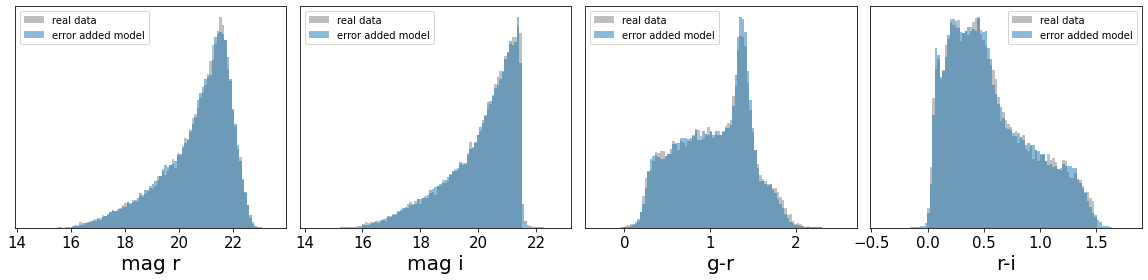

In [30]:
from xd import add_errors

# calling model
#FileName = 'output/test/fitting/gauss_gold_bovy.xdgmm'
clf_gold_bovy = XDnew_fitting_X( FileName = gold_xd_bovy_filename )
#clf_gold_astroml = XDastroML_fitting_X(FileName = gold_xd_astroml_filename)

# X_gold: real data
# X_gold_cov : error covariance assocated with data
# X_gold_model: extreme deconvolution model obtained from data (free from error)
# X_gold_model_noisy: artificial noise added to the extreme deconvolution model to make it look real data

X_gold_bovy_model = clf_gold_bovy.sample(80000)
X_gold_bovy_model_noisy = add_errors(X_gold_bovy_model, X_gold, X_gold_cov)

#X_gold_astroml_model = clf_gold_astroml.sample(20000)

# Comparison. real data vs. noise-added XD model
doVisualization_1d( data=[X_gold, X_gold_bovy_model], #, X_gold_astroml_model], 
                   labels = ['mag r', 'mag i', 'g-r', 'r-i'], 
                   ranges = None, 
                   name = ['real data', 'error added model'], 
                   weight = [None,None], 
                   nbins=100)

# Speed Test for the different size of training data

In [33]:

elapsed_time = []
# timing Bovy method for different sample size
for n_i in np.arange(1,11):
    
    gold_xd_bovy_filename_ni = gold_xd_bovy_filename+'.i{}'.format(str(n_i))
    
    # Put sample size you want 
    n_sample =  int(gold_st82.size/20 * n_i)  
    sampling_ind = np.random.choice(np.arange(gold_st82.size), size = n_sample)
    gold_st82_sub = gold_st82[sampling_ind]
    print('sample size =', n_sample)
    
    # structure data
    X_gold, X_gold_cov = mixing_color(gold_st82_sub, 
                    mag = mag, err=err, filter=filter, 
                    no_zband = True )

    # Determine the best number of Gaussian Mixtures to use 
    n_cl_gold,_,_= _FindOptimalN_with_err( np.arange(2, 50, 2), X_gold, X_gold_cov, 
                pickleFileName = gold_xd_bovy_filename_ni+'.n_cluster' , suffix = '')
    
    # Fitting start
    print ('start timing')
    t1 = time.time()
    clf_gold = XDnew_fitting_X( X_gold, X_gold_cov, FileName = gold_xd_bovy_filename_ni, 
                        n_cl = n_cl_gold, n_iter = n_iter_gold, tol = tol, method='Bovy')
    t2 = time.time()-t1
    elapsed_time.append(t2)
    #print ('elapsed time: ',t2%60, 's')  
    

sample size = 8263
@pickle_results: using precomputed results from 'output/test/fitting/gauss_gold_bovy.xdgmm.i1.n_cluster'
Finding optimal number of cluster : 100 % 
best fit converged: True  n_components =  12
start timing
n_components= 12
fit finished. elapsed time: 30.981290578842163 s
file saved to  output/test/fitting/gauss_gold_bovy.xdgmm.i1
sample size = 16527
@pickle_results: computing results and saving to 'output/test/fitting/gauss_gold_bovy.xdgmm.i2.n_cluster'
Finding optimal number of cluster : 100 % 
best fit converged: True  n_components =  22
start timing
n_components= 22
fit finished. elapsed time: 37.027477502822876 s
file saved to  output/test/fitting/gauss_gold_bovy.xdgmm.i2
sample size = 24790
@pickle_results: computing results and saving to 'output/test/fitting/gauss_gold_bovy.xdgmm.i3.n_cluster'
Finding optimal number of cluster : 100 % 
best fit converged: True  n_components =  30
start timing
n_components= 30
fit finished. elapsed time: 32.388566970825195 s
fil

In [34]:
print (elapsed_time)

[30.996947288513184, 157.06671023368835, 332.40741419792175, 419.1485526561737, 858.3061051368713, 900.7409245967865, 730.8350837230682, 1171.3625190258026, 979.1930067539215, 1601.4915063381195]


In [ ]:

elapsed_time_astroml = []
# timing Bovy method for different sample size
for n_i in np.arange(1,11):
    
    gold_xd_astroml_filename_ni = gold_xd_astroml_filename+'.i{}'.format(str(n_i))
    gold_xd_bovy_filename_ni = gold_xd_bovy_filename+'.i{}'.format(str(n_i))
    
    # Put sample size you want 
    n_sample =  int(gold_st82.size/10 * n_i)  
    sampling_ind = np.random.choice(np.arange(gold_st82.size), size = n_sample)
    gold_st82_sub = gold_st82[sampling_ind]
    print('sample size =', n_sample)
    
    # structure data
    X_gold, X_gold_cov = mixing_color(gold_st82_sub, 
                    mag = mag, err=err, filter=filter, 
                    no_zband = True )

    # Determine the best number of Gaussian Mixtures to use 
    n_cl_gold,_,_= _FindOptimalN_with_err( np.arange(2, 50, 2), X_gold, X_gold_cov, 
                pickleFileName = gold_xd_bovy_filename_ni+'.n_cluster' , suffix = '')
    
    # Fitting start
    print ('start timing')
    t1 = time.time()
    clf_gold = XDastroML_fitting_X( X_gold, X_gold_cov, FileName = gold_xd_astroml_filename_ni, 
                        n_cl = n_cl_gold, n_iter = n_iter_gold, tol = tol)
    t2 = time.time()-t1
    elapsed_time_astroml.append(t2)
    #print ('elapsed time: ',t2%60, 's')  
    

### Bovy's extreme deconvolution algorithm's computing time versus data size

In [17]:
elapsed_time=[30.996947288513184, 157.06671023368835, 332.40741419792175, 419.1485526561737, 858.3061051368713, 900.7409245967865, 730.8350837230682, 1171.3625190258026, 979.1930067539215, 1601.4915063381195]

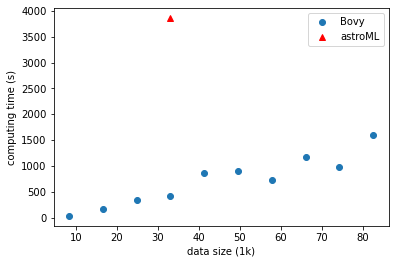

In [20]:
datasize = np.arange(1,11) * int(gold_st82.size/20)

fig, ax = plt.subplots()
ax.plot(datasize/1000, elapsed_time, 'o', label='Bovy')
ax.plot(datasize[3]/1000, 3861, 'r^', label='astroML')
ax.set_xlabel('data size (1k)')
ax.set_ylabel('computing time (s)')
ax.legend()

Using precomputed results from  output/test/fitting/gauss_gold_bovy.xdgmm.i10
Using central 100% to set range.


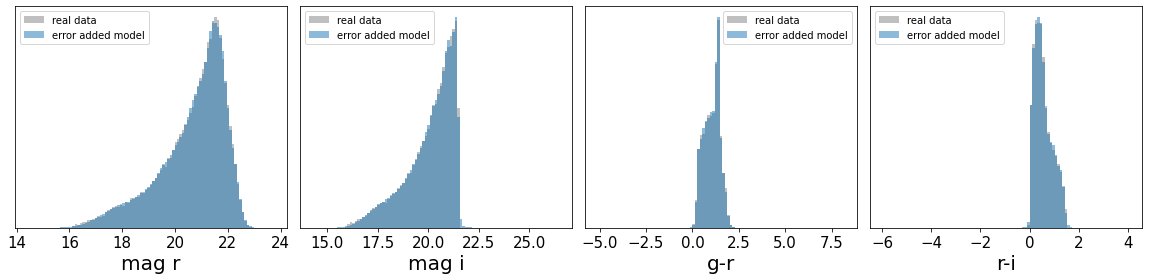

In [41]:
from xd import add_errors

# calling model
FileName = 'output/test/fitting/gauss_gold_bovy.xdgmm.i10'
clf_gold = XDnew_fitting_X( FileName = FileName )

# X_gold: real data
# X_gold_cov : error covariance assocated with data
# X_gold_model: extreme deconvolution model obtained from data (free from error)
# X_gold_model_noisy: artificial noise added to the extreme deconvolution model to make it look real data

X_gold_model = clf_gold.sample(gold_st82_sub.size)
X_gold_model_noisy = add_errors(X_gold_model, X_gold, X_gold_cov)

# Comparison. real data vs. noise-added XD model
doVisualization_1d( data=[X_gold, X_gold_model_noisy], 
                   labels = ['mag r', 'mag i', 'g-r', 'r-i'], 
                   ranges = None, 
                   name = ['real data', 'error added model'], 
                   weight = [None,None], 
                   nbins=100)